In [288]:
import pandas as pd
import numpy as np
import io
import requests
import matplotlib
import matplotlib.pyplot as plt
import math
import datetime
from IPython.display import Markdown, display
import locale

locale.setlocale(locale.LC_ALL, 'en_US')

def printmd(string):
    display(Markdown(string))

CSV_URL = "https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv"

csv_string = requests.get(CSV_URL).content
df = pd.read_csv(io.StringIO(csv_string.decode('utf-8')))


In [289]:
origin_datetime = datetime.datetime.strptime(df['Date'][0], '%Y-%m-%d')
countries = {'China': None, 'Italy': None, 'France': None, 'Spain': None, 'US': None, 'United Kingdom': None, 'Germany': None, 'India': None}
VERBOSE = 0
#df.head()



In [290]:
print("LAST UPDATES")
for country in countries:
    last_date = df[df['Country'] == country]['Date'].max()
    print("{:15} : {}".format(country[:15], last_date))

total_confirmed = df[df['Date'] == last_date]['Confirmed'].sum()
total_deaths = df[df['Date'] == last_date]['Deaths'].sum()
total_recovered = df[df['Date'] == last_date]['Recovered'].sum()
print("-----------------------------")
print("TOTAL CONFIRMED : {:10}".format(total_confirmed))
print("TOTAL DEATHS    : {:10}".format(total_deaths))
print("TOTAL RECOVERED : {:10}".format(total_recovered))
idx_max = df[df['Date'] == last_date]['Confirmed'].idxmax()
#df.iloc[idx_max]

df['Death_ratio'] = df['Deaths']/df['Confirmed']
top_confirmed_countries = df[df['Date'] == last_date].sort_values(['Confirmed'], ascending=0)[0:10]
top_confirmed_countries.reset_index()

LAST UPDATES
China           : 2020-04-12
Italy           : 2020-04-12
France          : 2020-04-12
Spain           : 2020-04-12
US              : 2020-04-12
United Kingdom  : 2020-04-12
Germany         : 2020-04-12
India           : 2020-04-12
-----------------------------
TOTAL CONFIRMED :    1846679
TOTAL DEATHS    :     114091
TOTAL RECOVERED :     421722


,index,Date,Country,Confirmed,Recovered,Deaths,Death_ratio
0,15156,2020-04-12,US,555313,32988,22020,0.039653
1,15141,2020-04-12,Spain,166831,62391,17209,0.103152
2,15069,2020-04-12,Italy,156363,34211,19899,0.127262
3,15046,2020-04-12,France,133670,27469,14412,0.107818
4,15050,2020-04-12,Germany,127854,60300,3022,0.023636
5,15160,2020-04-12,United Kingdom,85206,626,10629,0.124745
6,15021,2020-04-12,China,83134,77956,3343,0.040212
7,15065,2020-04-12,Iran,71686,43894,4474,0.062411
8,15155,2020-04-12,Turkey,56956,3446,1198,0.021034
9,15001,2020-04-12,Belgium,29647,6463,3600,0.121429


In [291]:
df_plot = pd.DataFrame()
# show unique countries
#np.unique(df['Country'])
min_offset = 99999999999
for country in countries:
    if VERBOSE:
        print("Processing: {}".format(country))
    cc = df[df['Country'] == country]['Confirmed'].tolist()
    if VERBOSE:
        print("Initial Len: {}".format(len(cc)))
    countries[country] = 0
    while cc[0] < 1000:
        cc = np.delete(cc, 0)
        cc = np.append(cc, [0])
        countries[country] += 1
    if VERBOSE:
        print("Final Len: {}, steps: {}".format(len(cc), countries[country]))
    df_plot[country] = cc
    if countries[country] < min_offset:
        min_offset = countries[country]


In [292]:
#df_plot.head()

China        --> peak: Feb 08; final total cases: 81,609  ; time constant: 4.6 days
Italy        --> peak: Mar 25; final total cases: 155,515 ; time constant: 6.3 days
France       --> peak: Apr 02; final total cases: 152,140 ; time constant: 5.1 days
Spain        --> peak: Mar 30; final total cases: 175,640 ; time constant: 5.1 days
US           --> peak: Apr 03; final total cases: 574,984 ; time constant: 4.2 days
United Kingd --> peak: Apr 04; final total cases: 96,171  ; time constant: 4.8 days
Germany      --> peak: Mar 29; final total cases: 133,015 ; time constant: 5.2 days
India        --> peak: Apr 17; final total cases: 36,296  ; time constant: 5.8 days


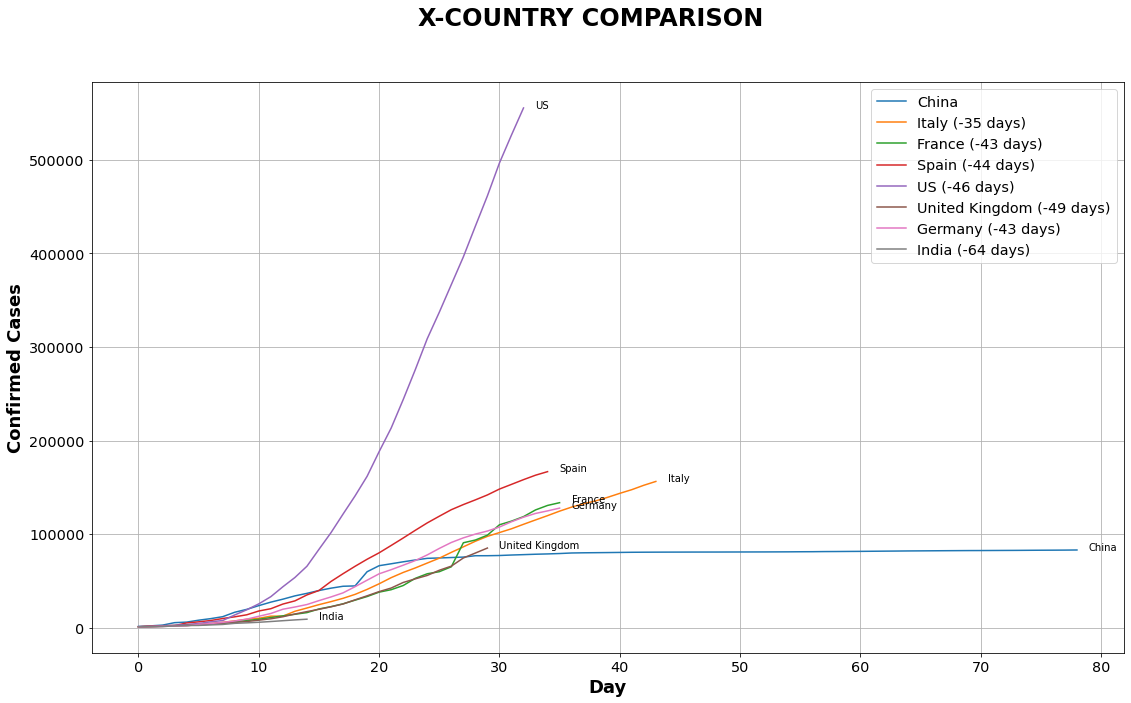

In [297]:
df_sim = pd.DataFrame()

A = {'Italy': 120000.0, 'China': 80000.0, 'France': 105000.0, 'Spain': 180000.0, 'US': 330000.0, 'Germany': 40000.0, 'United Kingdom': 50000.0, 'India': 50000.0}
D = {'Italy': 22.0, 'China': 14.0, 'France': 23.0, 'Spain': 21.0, 'US': 19.0, 'Germany': 20.0, 'United Kingdom': 20.0, 'India': 20.0}
T = {'Italy': 5.4, 'China': 4.0, 'France': 5.4, 'Spain': 5.0, 'US': 3.8, 'Germany': 5.0, 'United Kingdom': 5.0, 'India': 5.0}


def iterate_mse(df_plot, countries, country, param_name, A, D, T):
    epsilon_reference = {'A': 1000, 'D': 0.1, 'T': 0.2}
    max_loop = {'A': 100, 'D': 100, 'T': 100}
    epsilon = {'A': 0, 'D': 0, 'T': 0}
    epsilon[param_name] = epsilon_reference[param_name]
    epsilon_div = 0
    LAST_MOVE = None
    if VERBOSE:
        print("XXXXXXXXX BEGIN OF ITERATION {} XXXXXXXXX".format(param_name))
    relevant_length = len(df_plot[country])-countries[country]
    VERSION = 0
    if VERSION == 0:
        first_index_mse = 0
    else:
        first_index_mse = int(relevant_length / 6 * 5)
    #print("Country: {:13} - relevant_length: {:3} - first_index_mse: {:3}".format(country[:13], relevant_length, first_index_mse))    
    for loop in range(0,max_loop[param_name]):
        # zero
        # the sim array is calculated with full length len(df_plot[country])
        sim_0 = [A[country] / (1+math.exp((D[country]-x)/T[country])) for x in range(0,len(df_plot[country]))]
        # the mse is calculated only based on the relevant length and normalized
        mse_0 = ((df_plot[country][first_index_mse:relevant_length]-sim_0[first_index_mse:relevant_length])**2).sum() / (relevant_length - first_index_mse)
        # D+
        sim_plus = [(A[country] + epsilon['A']) / (1+math.exp((D[country] + epsilon['D'] - x)/(T[country] + epsilon['T']))) for x in range(0,len(df_plot[country]))]
        mse_plus = ((df_plot[country][first_index_mse:relevant_length]-sim_plus[first_index_mse:relevant_length])**2).sum() / (relevant_length - first_index_mse)
        # D-
        sim_minus = [(A[country] - epsilon['A']) / (1+math.exp((D[country] - epsilon['D'] - x)/(T[country] - epsilon['T']))) for x in range(0,len(df_plot[country]))]
        mse_minus = ((df_plot[country][first_index_mse:relevant_length]-sim_minus[first_index_mse:relevant_length])**2).sum() / (relevant_length - first_index_mse)
        if VERBOSE:
            print("{:3d} {} mse_minus = {:.3e} ; mse_0 = {:.3e} ; mse_plus = {:.3e}".format(loop, country, mse_minus, mse_0, mse_plus))
        if mse_plus < mse_0:
            if LAST_MOVE == "MINUS":
                    epsilon[param_name] /= 2
                    epsilon_div += 1
                    if VERBOSE:
                        print("* {} Epsilon / 2 : {:.4f} [{}]".format(param_name, epsilon[param_name], epsilon_div))
            A[country] += epsilon["A"]
            D[country] += epsilon["D"]
            T[country] += epsilon["T"]
            if VERBOSE:
                print(" {}  >>>>>>".format(param_name))
            LAST_MOVE = "PLUS"
        elif mse_minus < mse_0:
            if LAST_MOVE == "PLUS":
                    epsilon[param_name] /= 2
                    epsilon_div += 1
                    if VERBOSE:
                        print("* {} Epsilon / 2 : {:.4f} [{}]".format(param_name, epsilon[param_name], epsilon_div))
            A[country] -= epsilon["A"]
            D[country] -= epsilon["D"]
            T[country] -= epsilon["T"]
            if VERBOSE:
                print(" {}  <<<<<<".format(param_name))
            LAST_MOVE = "MINUS"
        else:
            # local min
            if VERBOSE:
                print(" {}  ======".format(param_name))
            if epsilon_div >= 6:
                if VERBOSE:
                    print("Local min found --> Breaking after {} loops".format(loop+1))
                break
            else:
                epsilon[param_name] /= 2
                epsilon_div += 1
                if VERBOSE:
                    print("* {} Epsilon / 2 : {:.4f} [{}]".format(param_name, epsilon[param_name], epsilon_div))
                LAST_MOVE = None
    if VERBOSE:
        print("{} {} --> mse = {:.1e} - Sim [0] = {:.0f}".format(country, param_name, mse_0, sim_0[0]))
        print("XXXXXXXXX END OF ITERATION {} XXXXXXXXX".format(param_name))
    return sim_0

    

for country in ['China', 'Italy', 'France', 'Spain', 'US', 'Germany', 'United Kingdom', 'India']:
    for big_loop in range(0,10):
        sim_0 = iterate_mse(df_plot, countries, country, "A", A, D, T)
        if VERBOSE:
            print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[country], D[country], T[country]))
        sim_0 = iterate_mse(df_plot, countries, country, "D", A, D, T)
        if VERBOSE:
            print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[country], D[country], T[country]))
        sim_0 = iterate_mse(df_plot, countries, country, "T", A, D, T)
        if VERBOSE:
            print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[country], D[country], T[country]))
    df_sim[country] = sim_0


# Chart with real data only
fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('X-COUNTRY COMPARISON', fontsize=24, fontweight='bold')
ax.set_xlabel('Day', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Confirmed Cases', fontsize=18, fontweight='bold')

for country in countries:
    if countries[country] == min_offset:
        ax.plot(df_plot[country][0:len(df_plot[country])-countries[country]], label="{}".format(country))
    else:
        ax.plot(df_plot[country][0:len(df_plot[country])-countries[country]], label="{} (-{} days)".format(country, countries[country] - min_offset))
    text_x_pos = len(df_plot[country])-countries[country]
    text_y_pos = df_plot[country][text_x_pos - 1]
    plt.text(text_x_pos, text_y_pos, country)

    peak_datetime = origin_datetime + datetime.timedelta(days=countries[country] + D[country])
    print("{:12} --> peak: {}; final total cases: {:8}; time constant: {:.1f} days".format(country[:12], peak_datetime.strftime("%b %d"), locale.format_string("%d", A[country], grouping=True), T[country]))
ax.grid()
ax.legend()

plt.show()


China      --> peak: Feb 08; final total cases: 81,609  ; time constant: 4.6 days
Italy      --> peak: Mar 25; final total cases: 155,515 ; time constant: 6.3 days
France     --> peak: Apr 02; final total cases: 152,140 ; time constant: 5.1 days
Spain      --> peak: Mar 30; final total cases: 175,640 ; time constant: 5.1 days
US         --> peak: Apr 03; final total cases: 574,984 ; time constant: 4.2 days
Germany    --> peak: Mar 29; final total cases: 133,015 ; time constant: 5.2 days
India      --> peak: Apr 17; final total cases: 36,296  ; time constant: 5.8 days


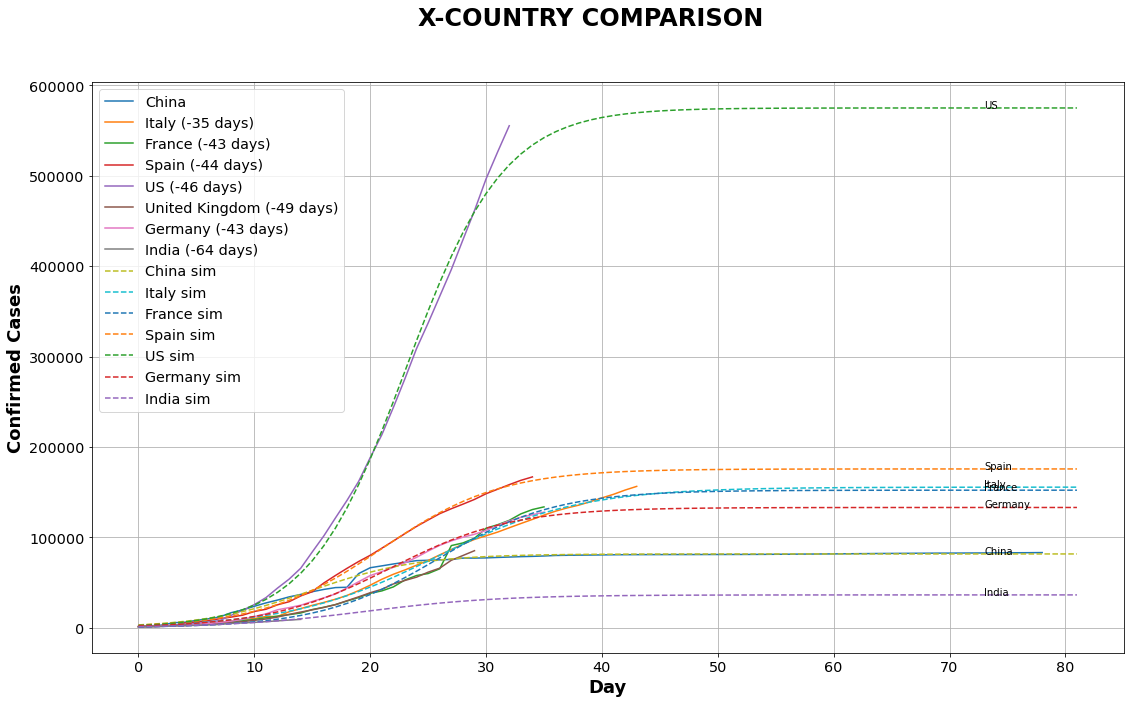

In [294]:
# Chart with real data + simulations
fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('X-COUNTRY COMPARISON', fontsize=24, fontweight='bold')
ax.set_xlabel('Day', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Confirmed Cases', fontsize=18, fontweight='bold')

for country in countries:
    if countries[country] == min_offset:
        ax.plot(df_plot[country][0:len(df_plot[country])-countries[country]], label="{}".format(country))
    else:
        ax.plot(df_plot[country][0:len(df_plot[country])-countries[country]], label="{} (-{} days)".format(country, countries[country] - min_offset))

for country in ['China', 'Italy', 'France', 'Spain', 'US', 'Germany', 'India']:
    ax.plot(df_sim[country], label = "{} sim".format(country), linestyle='dashed')
    text_x_pos = int(.9 * len(df_sim[country]))
    text_y_pos = int(df_sim[country][text_x_pos])
    plt.text(text_x_pos, text_y_pos, country)

    peak_datetime = origin_datetime + datetime.timedelta(days=countries[country] + D[country])
    print("{:10} --> peak: {}; final total cases: {:8}; time constant: {:.1f} days".format(country, peak_datetime.strftime("%b %d"), locale.format_string("%d", A[country], grouping=True), T[country]))
ax.grid()
ax.legend()

plt.show()

In [295]:
#np.unique(df['Country'])

In [296]:
timestamp = datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
printmd("<span style='color:black;font-size:12px'>Notebook generato il {}</span>".format(timestamp))

<span style='color:black;font-size:12px'>Notebook generato il 04/13/2020, 18:42:08</span>